In [3]:
import numpy as np
from itertools import product
from skimage import draw, transform

#def circle(size, val=None, r_shrink=0):
#    circle = np.zeros([size[0] + 1, size[1] + 1]) # 0 matrisi oluşturduk
#    rr, cc = draw.circle_perimeter( # daire çevre koordinatlarını oluşturuyoruz circle_perimeter -> daire çevresi
#        size[0] // 2, size[1] // 2, # dairenin merkez koordinatları
#        radius = size // 2, - r_shrink, # yarıçap
#        shape = [size[0] + 1, size[1] + 1] # çıktı piksel koordinatlarının maksimum kapsamını belirleyen görüntü şekli 
#    )
def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0) # resmi belirli bir boyuta uyacak şekilde yeniden boyutlandırdık
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # çekirdeği biçimlendiriyoruz
    kernel = np.array(kernel)
    if digits is not None:
        kernel = np.round(digits)
    
    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max() + kernel.min()) // 2
    
    # opsiyonel olarak etiket değerleri ekle
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255) # kernel'deki bir koordinat thresh'ten büyükse rengi açık mavi değilse koyu
            plt.text(j, i, val, color=color, size=text_size, horizontalalignment='center', verticalalignment='center')
            plt.xticks([])
            plt.yticks([])

def show_extraction(
    image,
    kernel,
    conv_stride=1,
    conv_padding='valid',
    activation='relu',
    pool_size=2,
    pool_stride=2,
    pool_padding='same',
    figsize=(10, 10),
    subplot_shape=(2, 2),
    ops=['Input', 'Filter', 'Detect', 'Condense'],
    gamma=1.0):
    
    # katmanları oluştur
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=kernel.shape,
            strides=conv_stride, # adımlar
            padding=conv_padding,
            use_bias=False,
            input_shape=image.shape,
        ),
        tf.keras.layers.Activation(activation),
        tf.keras.layers.MaxPool2D(
            pool_size = pool_size,
            strides = pool_stride,
            padding = pool_padding,
        ),
    ])
    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [3, 3, 1, 1])
    layer_filter.set_weights([kernel])
    
    # TF formatına dönüştür
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    # Öznitelik(özellik) çıkarma
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
        
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

Önceki dosyalarda görüntüden özellik çıkarma işlemini gerçekleştiren 3 işlemden bahsetmiştik:
1. Evrişim katmanı ile filtrele
2. ReLU activasyonuyla algıla
3. Maksimum havuzlama katmanı ile yoğunlaştır

Evrişim ve havuzlama operasyonları ortak bir özelliği paylaşır: Her ikisi de kayan bir pencere üzerinden gerçekleştirilir.<br>
Evrişim ile bu pencere çekirdeğin boyutları tarafından verilir. Parametre kernel_size<br>
Pooling ile pool_size tarafından verilen pooling penceresidir.

Evrişim ve pooling katmanlarını etkileyen 2 ek parametre vardır. Bunlar, pencerenin adımları(strides) ve görüntü kenarlarında dolgu(padding) kullanılıp kullanılmayacağıdır.<br>
strides parametresi, pencerenin her adımda ne kadar hareket etmesi gerektiğini söyler. padding parametresi, girişin kenarlarındaki pikselleri nasıl ele alacağımızı açıklar

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                 strides="1 - Convolutional_Classifier.ipynb",
                 padding='same',
                 activation='relu'),
    layers.MaxPool2D(pool_size=2,
                    strides=1,
                    padding='same')
])

# Stride

Pencerenin her adımda hareket ettiği mesafeye adım denir. Adımı görüntünün her iki boyutunda da belirtmemiz gerekiyor: Biri soldan sağa, diğeri yukarıdan aşağıya hareket için. Bu animasyon, her adımda 2 piksellik bir hareket olan strides=(2, 2) gösterir.<br><br>

Adımın etkisi nedir ?<br>
Her iki yöndeki adım, 1'den büyük olduğunda kayan pencere her adımda girişteki bazı pikselleri atlayacaktır.<br><br>

Sınıflandırma için yüksek kaliteli öznitelikler kullanmak istediğimizden,evrişimli katmanlar çoğunlukla strides=(1, 1) olacaktır. Adımı artırmak, özetimizdeki potansiyel olarak değerli bilgileri kaçırdığımız anlamına gelir. Maksimum havuzlama katmanları hemen hemen her zaman  (2, 2) veya (3, 3) gibi 1'den büyük adım sayısına sahip olacaktır, ancak pencerenin kendisinden daha büyük olmayacaktır.<br><br>
Son olarak adımların değeri her iki yönde de aynı sayı olduğunda,yalnızca bu sayıyı ayarlamamız gerektiğini unutmayalım; örneğin strides=(2, 2) yerine parametre için strides=2 kullanabiliriz.

# Padding

Tamamen giriş görüntüsünün içinde kalmak,pencerenin girşteki diğer tüm piksellerde olduğu gibi bu sınır piksellerinin üzerine asla tam olarak oturmayacağı anlamına gelir.<br>
Evrişimin bu sınır değerlerle ne yaptığı, padding parametresi tarafındann belirlenir.<br><br>

TensorFlow'da 2 seçeneğiniz vardır: padding='same' ve padding='valid'<br><br>

padding='valid' yaptığımızda, evrişim penceresi tamamen girdinin içide kalacaktır.Dezavantajı, çıktının küçülmesi (piksel kaybetmesi) ve daha büyük kernel'lar için daha fazla küçülmesidir.Bu, özellikle girdilerin boyutu küçük olduğunda, ağın içerebileceği katman sayısını sınırlayacaktır.<br><br>

Alternatif padding='same' kullanmaktır. Buradaki hile, çıktının boyutunun girdinin boyutuyla aynı yapmak için yeterli 0'ları kullanarak, girdiyi sınırları etrafında 0'larla doldurmaktır. Ancak bu, sınırlardaki piksellerin etkisini seyreltme etkisine sahip olabilir. 

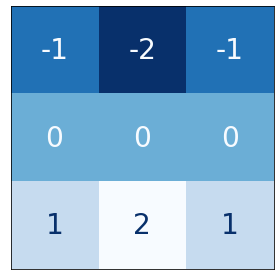

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])

# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]]
)

show_kernel(kernel)

VGG mimarisi oldukça basittir. 1'lik adımlarla evrişim ve 2x2 pencereli 2'lik adımlarla maksimum havuzlama kullanır.<br>
Visiontools yardımcı programı komut dosyasına bize tüm adımları gösterecek bir işlev ekledik.

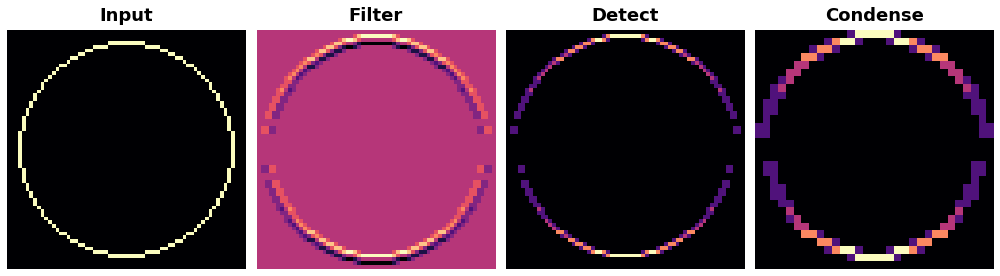

In [6]:
show_extraction(
    image, kernel,
    
    # Window parametreleri
    conv_stride=1,
    pool_size=2,
    pool_stride=2,
    
    subplot_shape=(1, 4),
    figsize=(14, 6)
)

Çekirdek yatay çizgileri algılamak için tasarlandı ve ortaya çıkan özellik haritasında girdinin daha yatay kısımlarının en büyük aktivasyonla sonuçlandıuğını görebiliriz.

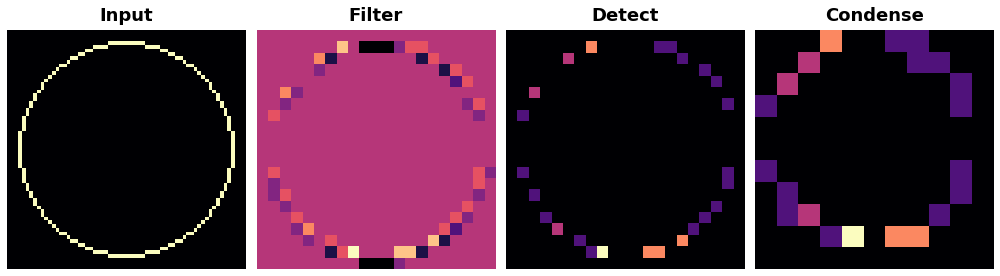

In [7]:
show_extraction(
    image, kernel,
    
    # Window parametreleri
    conv_stride=3,
    pool_size=2,
    pool_stride=2,
    
    subplot_shape=(1, 4),
    figsize=(14, 6),
)

conv_stride parametresinin değerinin 3 olması 1 olmasına göre kaliteyi düşürüyor.1 piksel genişliğinde oldukça ayrıntılıdır.<br><br>

Not: ResNet50 modeli, ilk katmanınnda 2 adımlı 7x7'lik çekirdek kullanır.Girdiden çok fazla feda etmeden büyük ölçekli özelliklerin üretimini hızlandırıyor.

Özetle<br><br>

Hem evrişim hem de havuzlama için ortak olan karakteristik bir hesaplama yaptık. Bunlar the sliding window(kayan pencere) ve bu katmanlardaki davranışını etkileyen parametrelerdir. Bu pencereli hesaplama tarzı, evrişimli ağların karakteristik özelliklerinin çoğuna katkıda bulunur ve işlevlerinin önemli bir parçasıdır.

# The Receptive Field (Alıcı Alan)
Bazı nöronlardan gelen tüm bağlantıları geriye doğru takip edin, sizi girdi nöronuna ulaştıracaktır.Bir nöronun bağlı olduğu tüm giriş pikselleri, o nöronun alıcı alanıdır.Alıcı alan, bir nöronun girdi görüntüsünün hangi bölümlerinden bilgi aldığını söyler.

# (Opsiyonel) Tek Boyutlu Evrişim
Evrişimli ağların yalnızca (iki boyutlu) görüntülerde değil, aynı zamanda zaman serisi (tek boyutlu) ve video (üç boyutlu) gibi şeylerde de yararlı olduğu ortaya çıktı.

Evrişimli ağların (iki boyutlu) görüntülerden öznitelikleri çıkarmayı nasıl öğrenebileceğini gördük. Convnet'lerin zaman serisi (tek boyutlu) ve video (üç boyutlu) gibi şeylerden özellikler çıkarmayı da öğrenebileceği ortaya çıktı.

Bir zaman serisinde evrişim nasıl olacağına bir bakalım.

Kullanacağımız zaman serisi Google Trendler'den. 25 Ocak 2015 ile 15 Ocak 2020 arasındaki haftalar için "makine öğrenimi" arama teriminin popülerliğini ölçer.

<AxesSubplot:xlabel='Week'>

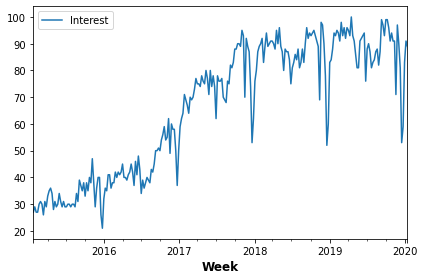

In [12]:
import pandas as pd

# Zaman serilerini bir pandas Dataframe'i olarak yükleyelim
machinelearning = pd.read_csv(
    'datas/machinelearning.csv',
    parse_dates=['Week'],
    index_col='Week',
)

machine_learning.plot()

Görüntülerimiz 2 boyutlu olduğu için kernel'larımız da 2 boyutluydu.Bir zaman serisi 1 boyutludur dolayısıyla kernel'lar da 1  boyutlu olmalıdır.İşte bazı zaman serisi verilerinde kullanılan bazı kernel'lar:

In [13]:
detrend = tf.constant([-1, 1], dtype=tf.float32)
average = tf.constant([0.2, 0.2, 0.2, 0.2, 0.2], dtype=tf.float32)
detrend = tf.constant([-3, -6, -5, 3, 21, 46, 67, 74, 67, 46, 32, 3, -5, -6, -3], dtype=tf.float32)

Bir dizideki evrişim, bir görüntüdeki evrişim gibi çalışır. Aradaki fark, bir dizideki kayan pencerenin, bir görüntüdeki iki yön yerine yalnızca bir yöne - soldan sağa - hareket etmesidir. Ve daha önce olduğu gibi, seçilen özellikler çekirdekteki sayıların örüntüsüne bağlıdır.

<AxesSubplot:>

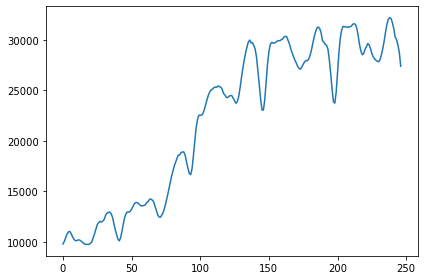

In [14]:
kernel = detrend
#kernel = average
#kernel = spencer        # istediğinizi seçebilirsiniz

# Reformat for TensorFlow
ts_data = machinelearning.to_numpy()
ts_data = tf.expand_dims(ts_data, axis=0)
ts_data = tf.cast(ts_data, dtype=tf.float32)
kern = tf.reshape(kernel, shape=(*kernel.shape, 1, 1))

ts_filter = tf.nn.conv1d(
    input=ts_data,
    filters=kern,
    stride=1,
    padding='VALID',
)

# Pandas serisi olarak formatladık
machinelearning_filtered = pd.Series(tf.squeeze(ts_filter).numpy())

machinelearning_filtered.plot()

Aslında, detrend kernel serideki filtrelerken, ortalama ve spencer, serideki düşük frekanslı bileşenleri filtreleyen "yumuşak"'tır.<br><br>

Arama terimlerinin gelecekteki popülaritesini tahmin etmekle ilgileniyorsanız, bunun gibi zaman serilerinde bir toplantıyı eğitebilirsiniz. Bu dizilerdeki hangi özelliklerin tahmin için en bilgilendirici olduğunu öğrenmeye çalışacaktı.

Konvnetler bu tür problemler için genellikle tek başına en iyi seçim olmasa da, özellik çıkarma yetenekleri nedeniyle genellikle diğer modellere dahil edilirler.<br><br>

